# Ultrasound imaging
Using the delay-and-sum beamforming algorithm (sparse matrix-multiplication version).

Note: because `stride` simulations are relatively time-consuming, the following notebook uses data simulated by the MATLAB Ultrasound Toolbox dataset.
It then checks against the MUST results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from neurotechdevkit.imaging import beamform, demodulate

In [2]:
must_data = scipy.io.loadmat('/Users/charles/Downloads/MUST_example (2).mat')
print(must_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'IQ', 'RC', 'RF', 'k', 'option', 'param', 'rf', 't', 'tilt', 'txdel', 'xi', 'xs', 'zi', 'zs'])


In [3]:
# Stack RF signals
rf_signal_lengths = [echo_rf_signal.shape[0] for echo_rf_signal in must_data["RF"].flatten()]
rf_signal_min_len = min(rf_signal_lengths)
rf_signal_stacked = np.stack(
    [
        echo_rf_signal[:rf_signal_min_len]
        for echo_rf_signal in must_data["RF"].flatten()
    ],
    axis=-1
)

rf_signal_stacked.shape

(1894, 128, 21)

In [16]:
# Demodulate IQ signals to RF signals
iq_signals, _ = demodulate.demodulate_rf_to_iq(
    rf_signal_stacked,
    must_data["param"]["fs"].item().item(),
    freq_carrier=must_data["param"]["fc"].item().item(),
#     bandwidth=must_data["param"]["bandwidth"].item().item() / 100,  # Convert % to fraction
)
iq_signals.shape

(1894, 128, 21)

In [17]:
must_data["IQ"].flatten()[0].shape

(2024, 128)

In [18]:
# # Check that the demodulated signals match the MUST results
# must_iq_signals = np.stack(
#     [x[:rf_signal_min_len] for x in must_data["IQ"].flatten()],
#     axis=-1,
# )

# np.testing.assert_allclose(
#     iq_signals,
#     must_iq_signals,
#     rtol=1e-3,
#     atol=1e-3,
# )

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0.001

Mismatched elements: 628 / 5091072 (0.0123%)
Max absolute difference: 1.30796327
Max relative difference: 21.09293091
 x: array([[[ 1.013931e-80+1.113476e-67j, -1.282045e-79+6.171052e-68j,
          6.235658e-78+2.280290e-65j, ..., -5.022874e-70-4.130168e-58j,
         -1.315040e-70-6.772547e-58j,  8.880722e-71-4.083507e-58j],...
 y: array([[[ 1.051005e-80+1.113476e-67j, -2.126370e-79+6.171052e-68j,
          6.014532e-78+2.280290e-65j, ..., -4.776755e-70-4.130168e-58j,
         -1.027808e-70-6.772547e-58j,  9.070946e-71-4.083507e-58j],...

In [33]:
num_tilts = must_data["k"].item()

In [29]:
# Beamform the IQ signals
num_tilts = must_data["k"].item()
iq_signals_beamformed = np.zeros(
    shape=must_data["xi"].shape + (num_tilts,),
    dtype=complex,
)
iq_signals_beamformed[:] = np.nan
for idx, txdel in enumerate(must_data["txdel"].flatten()):
    iq_signals_beamformed[:, :, idx] = beamform.beamform_delay_and_sum(
        iq_signals[:,:,idx],
        x=must_data["xi"],
        z=must_data["zi"],
        pitch=must_data["param"]["pitch"].item().item(),
        tx_delays=txdel.flatten(),
        fs=must_data["param"]["fs"].item().item(),
        fc=must_data["param"]["fc"].item().item(),
        f_number=None,
        width=must_data["param"]["width"].item().item(),
#         bandwidth=must_data["param"]["bandwidth"].item().item() / 100,  # Convert % to fraction
    )

In [ ]:
# Note: The MUST example uses linear interpolation, which we have not yet implemented. Instead, we use nearest-neighbor interpolation.

In [38]:
def bmode(IQ, DR=40):
    # DR is in DB
    assert np.iscomplexobj(IQ), 'IQ must be complex'
    
    I = np.abs(IQ)  # real envelope
    if DR > 1:
        I = 20 * np.log10(I / np.max(I)) + DR
        I = (255 * I / DR) # .astype(np.uint8)  # 8-bit log-compressed image
    else:
        I = np.power(I / np.max(I), DR)
        I = (255 * I) # .astype(np.uint8)  # 8-bit log-compressed image
        
    return I

Text(0, 0.5, '[m]')

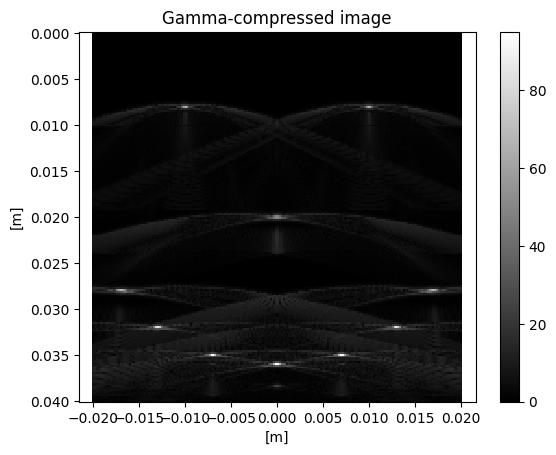

In [55]:
# Plot the beamformed IQ signals
plt.pcolormesh(
    must_data["xi"],
    must_data["zi"],
    np.abs(iq_signals_beamformed[:, :, num_tilts // 2])**0.5,
    cmap='gray',
#     vmax=0,
#     vmin=-800,
)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()  # Invert the y-axis to flip the image vertically
plt.title('Gamma-compressed image')
plt.xlabel('[m]')
plt.ylabel('[m]')

Text(0, 0.5, '[m]')

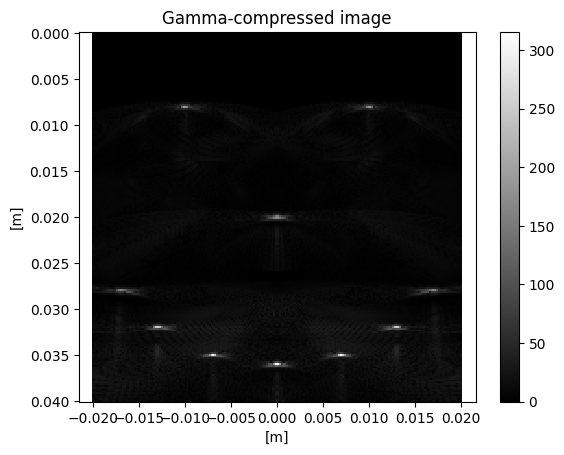

In [50]:
# Plot the beamformed IQ signals
plt.pcolormesh(
    must_data["xi"],
    must_data["zi"],
    np.abs(iq_signals_beamformed.sum(axis=-1))**0.5,
#         bmode(iq_signals_beamformed.sum(axis=-1)),
    cmap='gray'
)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()  # Invert the y-axis to flip the image vertically
plt.title('Gamma-compressed image')
plt.xlabel('[m]')
plt.ylabel('[m]')